# Pixel Art Classification Script with FastAI
This script uses the FastAI library to classify images of pixel art into two categories: `scenery` and `character`. Below is an explanation of the code and its functions.

## Step 1: Import Required Libraries
- **fastbook**: Provides useful FastAI utilities.
- **nbdev**: For notebook development workflows.
- **fastai.vision.widgets**: Includes widgets for data cleaning and visualization.

In [167]:
## Importing Required Libraries
import fastbook
import nbdev
from fastbook import *
from fastai.vision.widgets import *
import pathlib

## Step 2: Define Image Categories and Directory Path
- `image_types`: Categories to classify (`scenery` and `character`).
- `path`: Defines the folder where images will be stored.

In [168]:
image_types = 'scenery','character'
path = Path('pixel')

## Step 3: Create Directories and Download Images
- **Purpose**: Creates a directory structure and downloads images using DuckDuckGo.
- For each category:
  - Creates a subfolder.
  - Searches for images of the category using `search_images_ddg`.
  - Downloads images into the respective subfolder.

In [169]:
if not path.exists():
    print(path)
    path.mkdir()
    for o in image_types:
        print(o)
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} pixel art')
        print(f"Found {len(results)} images for {o} pixel art")
        download_images(dest, urls=results)

## Step 4: Verify and Remove Invalid Images
- **Purpose**: Ensures only valid image files are used.
- `get_image_files(path)`: Retrieves all image files.
- `verify_images(fns)`: Identifies invalid or corrupted images.
- `failed.map(Path.unlink)`: Deletes invalid files.

In [ ]:
fns = get_image_files(path)

In [ ]:
failed = verify_images(fns)
failed

In [14]:
failed.map(Path.unlink)

## Step 5: Define a DataBlock
- **DataBlock Definition**:
  - **Blocks**: Specifies input (images) and output (categories).
  - **get_items**: Collects images using `get_image_files`.
  - **splitter**: Splits data into training (80%) and validation (20%).
  - **get_y**: Extracts labels from parent folder names.
  - **item_tfms**: Resizes all images to 128x128.

In [146]:
pixels = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

## Step 6: Create Dataloaders and Visualize Validation Data
- **Dataloaders**: Prepares data for model training and validation.
- `show_batch`: Displays a sample batch of validation images for inspection.

In [147]:
dls = pixels.dataloaders(path)

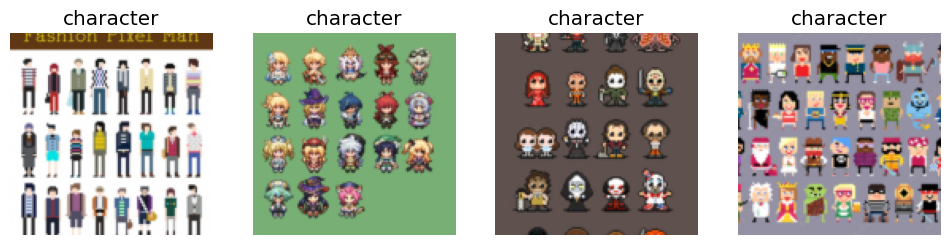

In [148]:
dls.valid.show_batch(max_n=4, nrows=1)

## Step 7: Experiment with Different Transformations
- Resizes images to 128x128 using zero-padding to maintain proportions.
- Adds augmentation transformations (e.g., rotation, flipping, warping).
- Crops images randomly to 224x224, ensuring a minimum scale of 50%.
- Applies additional augmentations.

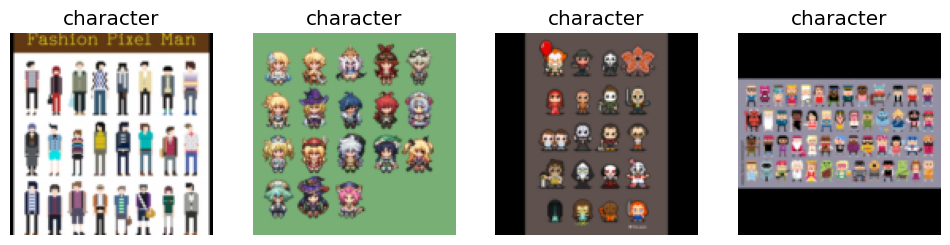

In [149]:
pixels = pixels.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = pixels.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

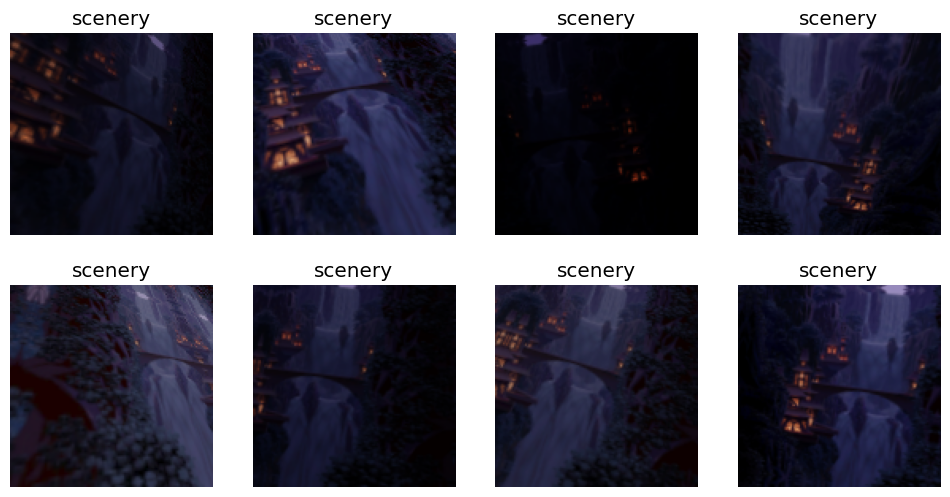

In [150]:
pixels = pixels.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pixels.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [152]:
pixels = pixels.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pixels.dataloaders(path)

## Step 8: Train the Model
- **Model Setup**:
  - Uses ResNet-18, a pre-trained convolutional neural network.
  - Optimizes with the `error_rate` metric.
- **Fine-Tuning**: Adapts the pre-trained model to the dataset over 4 epochs.

In [153]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.035487,0.246969,0.121212,00:08


C:\Users\joaol\OneDrive\Desktop\FastAI\envinroments\GPU\gpu_312env\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.255536,0.119773,0.045455,00:08
1,0.197169,0.131527,0.030303,00:08
2,0.150545,0.138114,0.030303,00:08
3,0.126429,0.138140,0.030303,00:08


## Step 9: Evaluate the Model
- **Confusion Matrix**: Visualizes correct and incorrect predictions.
- **Top Losses**: Displays images the model struggled with most.

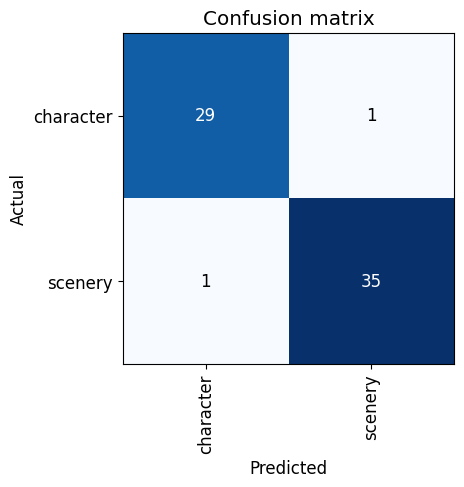

In [154]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

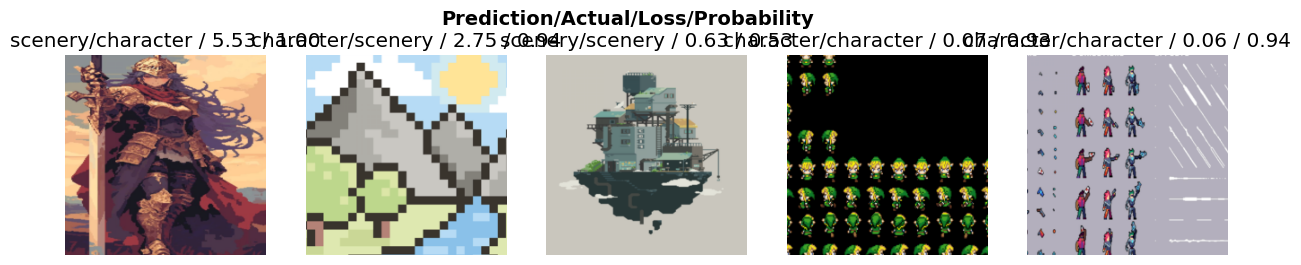

In [155]:
interp.plot_top_losses(5, nrows=1)

## Step 10: Clean the Dataset
- Interactive tool for inspecting and cleaning the dataset.
- Deletes mislabeled or unnecessary images.
- Moves images to the correct categories based on user input.
- This could be an iterative process where you can fit the model a few times removing images that are not appropriate.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [35]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [160]:
pathlib.WindowsPath = WindowsPath
pathlib.PosixPath = PosixPath

## Step 11: Export the Trained Model
- Saves the trained model to a file for future use or deployment.

In [ ]:
learn.export()